In [ ]:
import os
from google.colab import files
import zipfile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

uploaded = files.upload()

# Extract the uploaded zip file
for fn in uploaded.keys():
  if fn.endswith('.zip'):
    with zipfile.ZipFile(fn, 'r') as zip_ref:
      zip_ref.extractall('.')

# Update dataset_path to reflect the uploaded files' location
dataset_path = '.'
print("Digital images of defective and good condition tyres:")
print(os.listdir(dataset_path))

Digital images of defective and good condition tyres:
['.config', 'drive', 'sample_data']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set the path to dataset folder
dataset_path = '/content/drive/My Drive/Digital images of defective and good condition tyres'

# Verify the folder
import os
print("Dataset directory found at:", dataset_path)
print("Contents of the dataset folder:", os.listdir(dataset_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory found at: /content/drive/My Drive/Digital images of defective and good condition tyres
Contents of the dataset folder: ['desktop.ini', 'good', 'defective']


In [ ]:
import os
from PIL import Image

# Paths to the subdirectories for good and defective tyres
good_tyres_path = '/content/drive/My Drive/Digital images of defective and good condition tyres/good'
defective_tyres_path = '/content/drive/My Drive/Digital images of defective and good condition tyres/defective'

def verify_images(folder_path):
    valid_images = 0
    invalid_images = 0
    invalid_files = []

    # Check each image file in the folder
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        try:
            # Try to open the image to check if it's valid
            with Image.open(image_path) as img:
                img.verify()  # Verify if the image is valid
            valid_images += 1
        except (IOError, SyntaxError):
            # If there is an error, it's an invalid image
            invalid_images += 1
            invalid_files.append(image_name)

    return valid_images, invalid_images, invalid_files

# Verify images in both folders
valid_good, invalid_good, invalid_good_files = verify_images(good_tyres_path)
valid_defective, invalid_defective, invalid_defective_files = verify_images(defective_tyres_path)

print(f"Good Tyres - Valid: {valid_good}, Invalid: {invalid_good}")
print(f"Defective Tyres - Valid: {valid_defective}, Invalid: {invalid_defective}")

if invalid_good > 0:
    print(f"Invalid good tyre images: {invalid_good_files}")

if invalid_defective > 0:
    print(f"Invalid defective tyre images: {invalid_defective_files}")


Good Tyres - Valid: 91, Invalid: 0
Defective Tyres - Valid: 0, Invalid: 0


In [ ]:
import cv2
import os

def verify_images_opencv(folder_path):
    valid_images = 0
    invalid_images = 0
    invalid_files = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        try:
            # Try reading the image using OpenCV
            img = cv2.imread(image_path)

            # Check if the image was read properly
            if img is not None:
                valid_images += 1
            else:
                invalid_images += 1
                invalid_files.append(image_name)

        except Exception as e:
            # Handle any exceptions (corrupt files, etc.)
            invalid_images += 1
            invalid_files.append(image_name)

    return valid_images, invalid_images, invalid_files

# Verify the images in the 'defective' folder again
defective_tyres_path = '/content/drive/My Drive/Digital images of defective and good condition tyres/defective'
valid_defective, invalid_defective, invalid_defective_files = verify_images_opencv(defective_tyres_path)

print(f"Defective Tyres - Valid: {valid_defective}, Invalid: {invalid_defective}")
if invalid_defective > 0:
    print(f"Invalid defective tyre images: {invalid_defective_files}")


Defective Tyres - Valid: 272, Invalid: 0


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Define the image size
IMG_SIZE = (128, 128)  # Resize images to 128x128 pixels

# Set up ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to range [0, 1]
    rotation_range=40,            # Random rotations
    width_shift_range=0.2,        # Random horizontal shifts
    height_shift_range=0.2,       # Random vertical shifts
    shear_range=0.2,              # Random shearing
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Random horizontal flip
    fill_mode='nearest'           # Fill missing pixels after transformation
)

# Create a function to load and preprocess the images
def load_and_preprocess_images(folder_path, image_size=IMG_SIZE):
    images = []
    labels = []

    for label, subfolder in enumerate(['good', 'defective']):
        subfolder_path = os.path.join(folder_path, subfolder)

        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_name)

            try:
                # Load and resize the image
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load and preprocess the images
dataset_path = '/content/drive/My Drive/Digital images of defective and good condition tyres'
X, y = load_and_preprocess_images(dataset_path)

# Apply data augmentation on the images
augmented_images = datagen.flow(X, y, batch_size=32)

print("Preprocessing completed! Ready for training.")


Preprocessing completed! Ready for training.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # 128x128 images with 3 channels (RGB)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

# Output layer (2 classes: good or defective)
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(augmented_images, steps_per_epoch=len(X) // 32, epochs=10, verbose=1)

# Save the model after training
model.save('tyre_fault_model.h5')

print("Model training complete!")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5146 - loss: 0.7575
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5938 - loss: 0.6779
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5469 - loss: 0.6781
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.6250 - loss: 0.6100 
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6385 - loss: 0.6498
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - accuracy: 0.6562 - loss: 0.6549 
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6350 - loss: 0.6391
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - accuracy: 0.7188 - loss: 0.5874 
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6629 - loss: 0.6123
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - accuracy: 0.6562 - loss: 0.6156 


Model training complete!


In [ ]:
model.save('tyre_fault_model.keras')


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the dataset folder
dataset_path = '/content/drive/My Drive/Digital images of defective and good condition tyres'

# Load images and their corresponding labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), target_size=(128, 128))
        if img is not None:
            img_array = img_to_array(img) / 255.0  # Normalize the images
            images.append(img_array)
            labels.append(label)
    return images, labels

# Load images from both "good" and "defective" folders
good_images, good_labels = load_images_from_folder(os.path.join(dataset_path, 'good'), 0)  # 0 for good
defective_images, defective_labels = load_images_from_folder(os.path.join(dataset_path, 'defective'), 1)  # 1 for defective

# Combine the images and labels
all_images = np.array(good_images + defective_images)
all_labels = np.array(good_labels + defective_labels)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Convert into tensorflow datasets if needed, or use as input for the model
train_data = (X_train, y_train)
test_data = (X_test, y_test)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator for normalization and augmentation
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generate data batches for training and testing
train_data = datagen.flow(X_train, y_train, batch_size=32)
test_data = datagen.flow(X_test, y_test, batch_size=32)


In [ ]:
model.fit(train_data, epochs=10, validation_data=test_data)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5532 - loss: 2.1622 - val_accuracy: 0.4439 - val_loss: 0.6946
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4521 - loss: 0.6942 - val_accuracy: 0.5561 - val_loss: 0.6927
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4959 - loss: 0.6925 - val_accuracy: 0.5561 - val_loss: 0.6908
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5218 - loss: 0.6899 - val_accuracy: 0.5561 - val_loss: 0.6879
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5604 - loss: 0.6893 - val_accuracy: 0.5561 - val_loss: 0.6875
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5589 - loss: 0.6917 - val_accuracy: 0.5561 - val_loss: 0.6879
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5854 - loss: 0.6851 - val_accuracy: 0.5561 - val_loss: 0.6870
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5764 - loss: 0.6851 - val_accuracy: 0.5561 - val_loss: 0.6869
Epo

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - accuracy: 0.5389 - loss: 0.6904
Test Accuracy: 0.5561224222183228
Test Loss: 0.6868442893028259


In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step


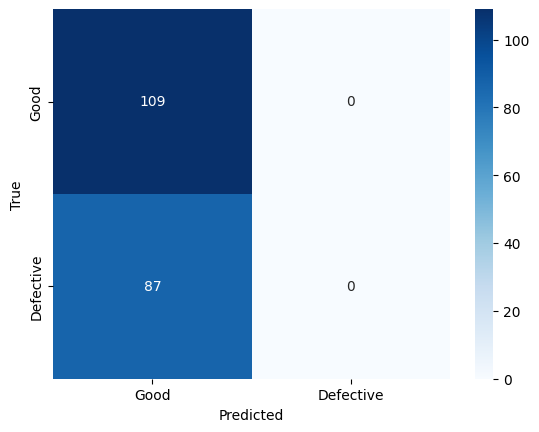

              precision    recall  f1-score   support

           0       0.56      1.00      0.71       109
           1       0.00      0.00      0.00        87

    accuracy                           0.56       196
   macro avg       0.28      0.50      0.36       196
weighted avg       0.31      0.56      0.40       196



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from the model
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Defective'], yticklabels=['Good', 'Defective'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [ ]:
class_weights = {0: 1, 1: 5}  # Assign a higher weight to the minority class (class 1)
model.fit(train_data, epochs=10, class_weight=class_weights)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 166s 7s/step - accuracy: 0.4492 - loss: 3.6801
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.4323 - loss: 1.4633
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.4110 - loss: 1.4142
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 201s 7s/step - accuracy: 0.4669 - loss: 1.3971
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - accuracy: 0.4159 - loss: 1.4079
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - accuracy: 0.4294 - loss: 1.4340
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.4587 - loss: 1.4061
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 162s 6s/step - accuracy: 0.4193 - loss: 1.5144
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.4160 - loss: 1.4206
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.4357 - loss: 1.4198


In [ ]:
y_pred = (model.predict(test_data) > 0.4).astype("int32")  # Lowering the threshold to 0.4


7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step
